## Install conda-merlin

In [1]:
!pip install git+https://github.com/marcromeyn/merlin-colab.git
from IPython import get_ipython
get_ipython().kernel.do_shutdown(True)

  Cloning https://github.com/marcromeyn/merlin-colab.git to /tmp/pip-req-build-4b20jo3g
  Running command git clone -q https://github.com/marcromeyn/merlin-colab.git /tmp/pip-req-build-4b20jo3g
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for merlin-colab: filename=merlin_colab-0.1-cp37-none-any.whl size=14714 sha256=4be57da4c89d221ea517321f5d005c8e7b1ee3ff12a4e8ce9247119043276b47
  Stored in directory: /tmp/pip-ephem-wheel-cache-bhney_hn/wheels/dd/a4/69/5515d1e3b0173aa6cdbb2a6515f12149147a6923425c9078ad
Successfully built merlin-colab


{'restart': True, 'status': 'ok'}

## Install Merlin
*Takes around 13 min*

In [1]:
import merlin_colab

merlin_colab.install_merlin()

⏬ Downloading https://repo.anaconda.com/miniconda/Miniconda3-py37_4.9.2-Linux-x86_64.sh...
📦 Installing conda...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:20
📦 Installing Rapids...

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.

Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.


Solving environment: ...working... done



## Package Plan ##



  environment location: /usr/local



  added / updated specs:

    - cudatoolkit=11.0

    - python=3.7

    - rapids=0.19





The following packages will be downloaded:



    package                    |            build

    ---------------------------|-----------------

    _libgcc_mutex-0.1          |      conda_forge           3 KB  conda-forge

    _openmp_mutex-4.5          |            1_gnu          22 KB  conda-forge

    abseil-cpp-20210324.1      |       h9c3ff4c_0        1015 KB  

## Using Merlin

### Imports

In [1]:
import os
import shutil
from tqdm import tqdm

# we can control how much memory to give tensorflow with this environment variable
# IMPORTANT: make sure you do this before you initialize TF's runtime, otherwise
# TF will have claimed all free GPU memory
os.environ["TF_MEMORY_ALLOCATION"] = "0.7"  # fraction of free memory

import pandas as pd
import tensorflow as tf
from tensorflow.experimental.dlpack import to_dlpack as tf_to_dlpack

import cudf
import dask_cudf
import nvtabular as nvt
from nvtabular.loader.tensorflow import KerasSequenceLoader
from merlin_colab.movielens import MovieLensData
from merlin_colab import nvt_extended

### Loading Movielens 25M dataset

In [2]:
DATA_DIR = "movielens/data/"
movielens = MovieLensData.load(DATA_DIR)

print(movielens)
movielens.movies_df

downloading ml-25m.zip: 262MB [00:09, 26.8MB/s]                           
unzipping files: 100%|██████████| 8/8 [00:07<00:00,  1.13files/s]


MovieLensData(train_path='movielens/data/train.parquet', eval_path='movielens/data/valid.parquet', movies_path='movielens/data/movies_converted.parquet')


,movieId,genres
0,1,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,"[Adventure, Children, Fantasy]"
2,3,"[Comedy, Romance]"
3,4,"[Comedy, Drama, Romance]"
4,5,[Comedy]
...,...,...
62418,209157,[Drama]
62419,209159,[Documentary]
62420,209163,"[Comedy, Drama]"
62421,209169,[(no genres listed)]


### Transforming data using [NVTabular](https://github.com/NVIDIA/NVTabular)

Fitting dataset...
Transforming train-dataset...
Transforming eval-dataset...
Dataset(train_path='movielens/transformed/train', eval_path='movielens/transformed/valid', categorical_features=['userId', 'movieId', 'genres'], continuous_features=[], targets=['rating'])


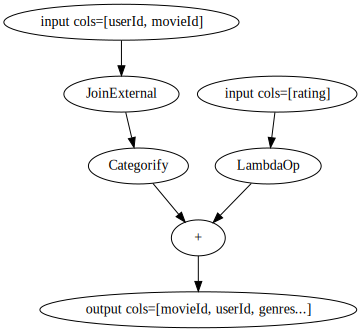

In [3]:
CATEGORICAL_COLUMNS = ["userId", "movieId"]
LABEL_COLUMNS = ["rating"]
TRANSFORMED_DIR = "movielens/transformed/"

cat_features = (["userId", "movieId"] 
          >> nvt.ops.JoinExternal(movielens.movies_df, on=["movieId"])
          >> nvt.ops.Categorify()
          )

# Make rating a binary target
rating = nvt.ColumnGroup(["rating"]) >> (lambda col: (col > 3).astype("int8"))

output = cat_features + rating
workflow = nvt.Workflow(output)
transformed_data = movielens.transform(TRANSFORMED_DIR, workflow,
                                       continuous_features=[],
                                       categorical_features=CATEGORICAL_COLUMNS + ["genres"],
                                       targets=LABEL_COLUMNS)
print(transformed_data)
output.graph

## Training a model using TensorFlow

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


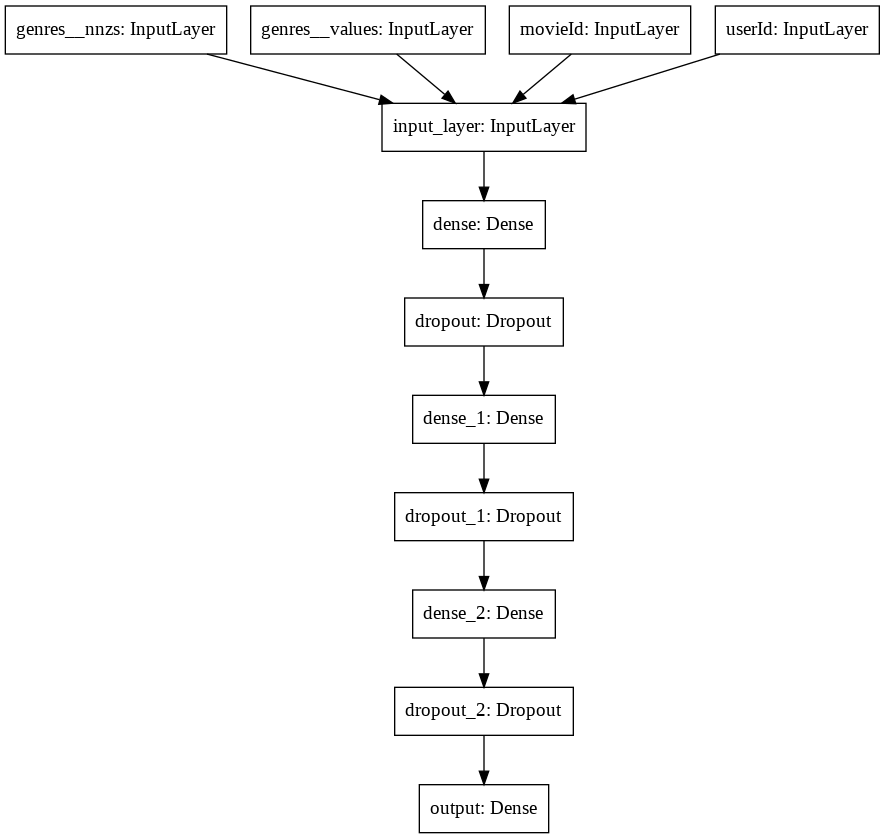

In [4]:
layer_dims = [512, 256, 128]
dropout = 0.5

inputs = transformed_data.create_keras_inputs(sparse_columns=["genres"])
x = transformed_data.create_default_input_layer(workflow)(inputs)
for dim in layer_dims:
    x = tf.keras.layers.Dense(dim, activation="relu")(x)
    x = tf.keras.layers.Dropout(dropout)(x)
x = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.compile("sgd", "binary_crossentropy", 
              metrics=[tf.keras.metrics.AUC(), 
                       tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.BinaryCrossentropy()])

tf.keras.utils.plot_model(model)

In [5]:
BATCH_SIZE = 10000

train_dataset_tf = transformed_data.train_tf_dataset(BATCH_SIZE)

model.fit(train_dataset_tf, 
          callbacks=[transformed_data.eval_tf_callback(BATCH_SIZE)], 
          epochs=1)

2001/2001 [==============================] - 41s 18ms/step - loss: 0.6632 - auc: 0.5087 - binary_accuracy: 0.6241 - binary_crossentropy: 0.6632
{'val_loss': 0.6582213, 'val_auc': 0.5136217, 'val_binary_accuracy': 0.62435216, 'val_binary_crossentropy': 0.6624962}


In [6]:
result_dict = model.evaluate(transformed_data.eval_tf_dataset(BATCH_SIZE), return_dict=True)
pd.DataFrame({key: [val] for key, val in result_dict.items()})

501/501 [==============================] - 6s 10ms/step - loss: 0.6597 - auc: 0.5541 - binary_accuracy: 0.6254 - binary_crossentropy: 0.6597


,loss,auc,binary_accuracy,binary_crossentropy
0,0.659663,0.554102,0.625432,0.659663


## Model predictions

In [7]:
PREDICT_PATH = "movielens/predictions/"
cols_to_include = ["userId", "movieId"]
add_genres = True

eval_set: KerasSequenceLoader = transformed_data.eval_tf_dataset(int(1e5))

if os.path.exists(PREDICT_PATH):
  shutil.rmtree(PREDICT_PATH)
os.makedirs(PREDICT_PATH, exist_ok=True)

for i, batch in tqdm(enumerate(eval_set)):
  df = cudf.DataFrame()
  for col in cols_to_include:
    df[col] = cudf.from_dlpack(tf_to_dlpack(batch[0][col]))

  df["prediction"] = cudf.from_dlpack(tf_to_dlpack(model.predict_step(batch[0])))
  df["target"] = cudf.from_dlpack(tf_to_dlpack(batch[1]))

  if add_genres:
    df = df.merge(movielens.movies_df, on="movieId")

  df.to_parquet(os.path.join(PREDICT_PATH, f"predictions_{i}.parquet"))

predictions = dask_cudf.read_parquet(os.path.join(PREDICT_PATH, "*.parquet"))

predictions.head()

51it [00:09,  5.60it/s]


,userId,movieId,prediction,target,genres
0,82018,4772,0.621748,1,[Drama]
1,70601,7925,0.634678,1,"[Action, Adventure]"
2,46638,1641,0.637744,1,"[Comedy, Drama]"
3,32808,1214,0.658471,0,"[Horror, Sci-Fi]"
4,38097,2203,0.613828,0,"[Crime, Drama, Thriller]"
